In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns 
import statsmodels.stats.proportion as proportion
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind,mannwhitneyu,shapiro,norm
from statsmodels.stats.weightstats import ztest
from tqdm import tqdm
import timeit
from scipy import stats
import math
from datetime import date, datetime, timedelta
import time
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import warnings
warnings.filterwarnings("ignore")
import clickhouse_connect  



sys.path.append('/Users/kemran/Desktop/work_files/python_files') 
from credential import postgres_secret,clickhouse_dwh_secret

def get_engine(user):
    if user == postgres_secret['user']:
        db_name = postgres_secret['db_name']
        password = postgres_secret['password']
        host = postgres_secret['host']
        engine = create_engine(f'postgresql://{user}:{password}@{host}:6432/{db_name}')
    elif user == clickhouse_dwh_secret['user']:
            db_name = clickhouse_dwh_secret['db_name'] 
            password = clickhouse_dwh_secret['password']
            host = clickhouse_dwh_secret['host']
            engine = create_engine(f'clickhouse://{user}:{password}@{host}:8123/{db_name}')
    
connection_clickhouse = clickhouse_connect.get_client(
    host = clickhouse_dwh_secret['host'],
    port= '8123',
    username = clickhouse_dwh_secret['user'],
    password = clickhouse_dwh_secret['password'],
    database='datamarts'
    )

    
def execute(SQL, user):
    start_time = time.time()  # запоминаем время начала выполнения функции
    engine = get_engine(user)
    Session = sessionmaker(bind=engine)  # sessions factory ()
    with Session() as session: # open session
        result = session.execute(text(SQL))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        
    end_time = time.time()  # запоминаем время окончания выполнения функции
    execution_time = round(end_time - start_time,4) # вычисляем время выполнения   
    
    print(f"Время выполнения функции: {execution_time} секунд")
    print()
    return df

## Выгузка подневная для графиков

In [7]:
start_date = '2024-11-12'
end_date = '2024-11-26'
query = f'''WITH user AS (SELECT 
                    utc_timestamp,
                    date,
                    user_id,
                    event_name,
                    client_type,
                    app_version,
                    free_days,
                    payload,
                    created_at,
                    end_date,
                    first_prolong_date,
                    payment,
                    t2.bonus_title_new AS bonus_title_new,
                    CASE WHEN event_name='click_subscribe_manage_cancel' 
                            AND (utc_timestamp BETWEEN created_at AND end_date)
                            AND (first_prolong_date='1970-01-01' OR first_prolong_date>created_at::date) 
                         THEN 1 ELSE 0
                    END AS click_subscribe_manage_cancel,
                    CASE WHEN event_name='click_subscribe_manage_popup' 
                            AND JSONExtractString(payload,'button')='true'
                            AND (utc_timestamp BETWEEN created_at AND end_date)
                            AND (first_prolong_date='1970-01-01' OR first_prolong_date>created_at::date) 
                         THEN 1 ELSE 0
                    END AS click_subscribe_manage_popup,
                    CASE WHEN event_name='click_subscribe_cancel_last_chance' 
                             AND JSONExtractString(payload,'button')='true'
                             AND (utc_timestamp BETWEEN created_at AND end_date)
                             AND (first_prolong_date='1970-01-01' OR first_prolong_date>created_at::date)
                         THEN 1 ELSE 0 
                    END AS click_subscribe_cancel_last_chance,
                    JSONExtractString(JSONExtractString(payload,'flags'),'cancel_of_subs') AS flags
                    FROM (SELECT
                        user_id,utc_timestamp,date,event_name,created_at,DATE_ADD(created_at, INTERVAL free_days DAY) AS end_date,
                        bonus_title,client_type,app_version,free_days,first_prolong_date,payload,price_cents/100 AS payment
                        FROM datamarts.sandbox_data_distr
                        WHERE event_name IN ('click_subscribe_manage_cancel','click_subscribe_manage_popup','click_subscribe_cancel_last_chance')
                        AND date BETWEEN '{start_date}' and '{end_date}'
                        AND user_id IS NOT NULL
                        GROUP BY 1,2,3,4,5,6,7,8,9,10,11,12,13
                        ) AS t1
                    LEFT JOIN datamarts.mekhtiev_bonus_distr AS t2
                    ON t1.bonus_title=t2.bonus_title_old
),

users_final AS (SELECT 
                date,
                user_id,
                bonus_title_new,
                free_days,
                flags,
                max(app_version) AS app_version,
                max(client_type) AS client_type,
                max(click_subscribe_manage_cancel) AS click_subscribe_manage_cancel,
                max(click_subscribe_manage_popup) AS click_subscribe_manage_popup,
                max(click_subscribe_cancel_last_chance) AS click_subscribe_cancel_last_chance
                FROM user
                GROUP BY 1,2,3,4,5
                ),
                
---Дедуппликация пользователей с несколькими группами --------
duplicate AS (SELECT user_id,uniq(flags) AS cnt_uniq_flag
                FROM users_final
                WHERE flags!=''
                GROUP BY 1
               )
               
                
-------Убираем дубликаты ----------                
SELECT t1.* FROM users_final AS t1
LEFT JOIN (SELECT * FROM duplicate WHERE cnt_uniq_flag>1) AS t2
ON t1.user_id=t2.user_id
WHERE t2.user_id IS NULL 
 
 
'''

df = execute(query,user='kmekhtiev')
df['date'] = df['date'].astype('datetime64[ns]')

Время выполнения функции: 2.635 секунд



In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1942 entries, 0 to 1941
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   date                                1942 non-null   datetime64[ns]
 1   user_id                             1942 non-null   object        
 2   bonus_title_new                     1942 non-null   object        
 3   free_days                           1942 non-null   int64         
 4   flags                               1942 non-null   object        
 5   app_version                         1942 non-null   object        
 6   client_type                         1942 non-null   object        
 7   click_subscribe_manage_cancel       1942 non-null   int64         
 8   click_subscribe_manage_popup        1942 non-null   int64         
 9   click_subscribe_cancel_last_chance  1942 non-null   int64         
dtypes: datetime64[ns](1), in

In [11]:
df['date'].unique()

<DatetimeArray>
['2024-11-26 00:00:00', '2024-11-25 00:00:00', '2024-11-23 00:00:00',
 '2024-11-24 00:00:00', '2024-11-13 00:00:00', '2024-11-16 00:00:00',
 '2024-11-20 00:00:00', '2024-11-22 00:00:00', '2024-11-19 00:00:00',
 '2024-11-15 00:00:00', '2024-11-21 00:00:00', '2024-11-18 00:00:00',
 '2024-11-17 00:00:00', '2024-11-14 00:00:00', '2024-11-12 00:00:00']
Length: 15, dtype: datetime64[ns]

In [13]:
df['client_type'].unique()

array(['web_desktop', 'web_mobile'], dtype=object)

In [91]:
df_experiment = df[df['flags'].isin(['group_a','group_b']) & (df['click_subscribe_manage_cancel']==1)]

In [93]:
t = pd.DataFrame(data = df_experiment[['click_subscribe_manage_cancel','click_subscribe_manage_popup','click_subscribe_cancel_last_chance']].sum(),columns=['cnt_user'])
t['percantege'] = round(t['cnt_user']/t.iloc[0,0] * 100)
print(f' {7} дней:')
print(t)
print()

 7 дней:
                                    cnt_user  percantege
click_subscribe_manage_cancel           1615       100.0
click_subscribe_manage_popup            1433        89.0
click_subscribe_cancel_last_chance      1314        81.0



In [95]:
df_experiment.groupby('flags')[['click_subscribe_manage_cancel','click_subscribe_manage_popup','click_subscribe_cancel_last_chance']].sum()

,click_subscribe_manage_cancel,click_subscribe_manage_popup,click_subscribe_cancel_last_chance
flags,,,
group_a,936,847,789
group_b,679,586,525


In [97]:
df_experiment.groupby(['client_type','flags'])[['click_subscribe_manage_cancel','click_subscribe_manage_popup','click_subscribe_cancel_last_chance']].sum()

click_subscribe_manage_cancel  \
client_type flags                                    
web_desktop group_a                            268   
            group_b                            236   
web_mobile  group_a                            668   
            group_b                            443   

                     click_subscribe_manage_popup  \
client_type flags                                   
web_desktop group_a                           240   
            group_b                           213   
web_mobile  group_a                           607   
            group_b                           373   

                     click_subscribe_cancel_last_chance  
client_type flags                                        
web_desktop group_a                                 219  
            group_b                                 190  
web_mobile  group_a                                 570  
            group_b                                 335

In [99]:
df.groupby(['date','flags'])['user_id'].nunique().reset_index()

,date,flags,user_id
0,2024-11-12,group_a,72
1,2024-11-12,group_b,60
2,2024-11-13,group_a,74
3,2024-11-13,group_b,55
4,2024-11-14,group_a,72
5,2024-11-14,group_b,44
6,2024-11-15,group_a,83
7,2024-11-15,group_b,43
8,2024-11-16,group_a,81
9,2024-11-16,group_b,71


In [101]:
df.groupby(['date','client_type','flags'])['user_id'].nunique().reset_index()

,date,client_type,flags,user_id
0,2024-11-12,web_desktop,group_a,21
1,2024-11-12,web_desktop,group_b,25
2,2024-11-12,web_mobile,group_a,51
3,2024-11-12,web_mobile,group_b,35
4,2024-11-13,web_desktop,group_a,16
...,...,...,...,...
56,2024-11-25,web_mobile,group_b,40
57,2024-11-26,web_desktop,group_a,15
58,2024-11-26,web_desktop,group_b,14
59,2024-11-26,web_mobile,group_a,46


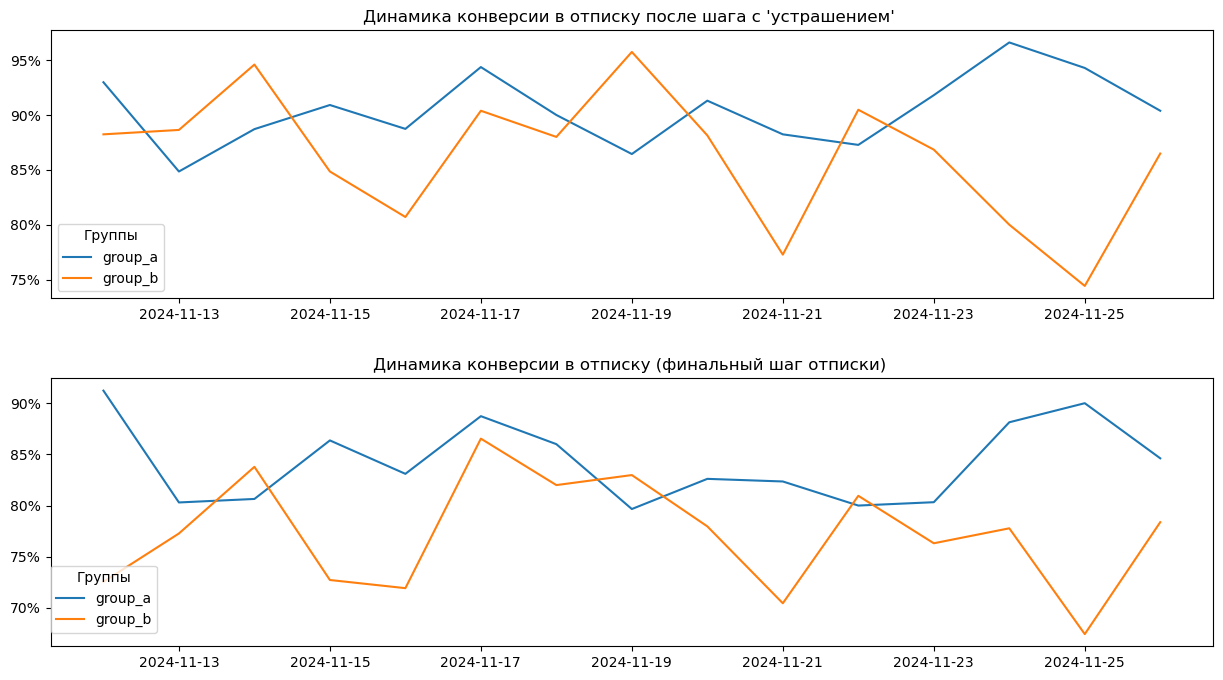

In [103]:
df_agg = df_experiment.groupby(['date','flags'],as_index=False)[['click_subscribe_manage_cancel','click_subscribe_manage_popup','click_subscribe_cancel_last_chance']].sum()

df_agg['next_step_after_scare'] = df_agg['click_subscribe_manage_popup'] / df_agg['click_subscribe_manage_cancel']
df_agg['final_step'] = df_agg['click_subscribe_cancel_last_chance'] / df_agg['click_subscribe_manage_cancel']


fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(15,8))
sns.lineplot(data=df_agg,x='date',y='next_step_after_scare',hue='flags', ax=ax[0])
ax[0].set_title("Динамика конверсии в отписку после шага с 'устрашением' ")
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].legend(title='Группы')
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))


sns.lineplot(data=df_agg,x='date',y='final_step',hue='flags',ax=ax[1])
ax[1].set_title("Динамика конверсии в отписку (финальный шаг отписки) ")
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].legend(title='Группы',loc=(0,0.05))
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))

plt.subplots_adjust(hspace=0.3)
plt.show()  

### WEB desktop

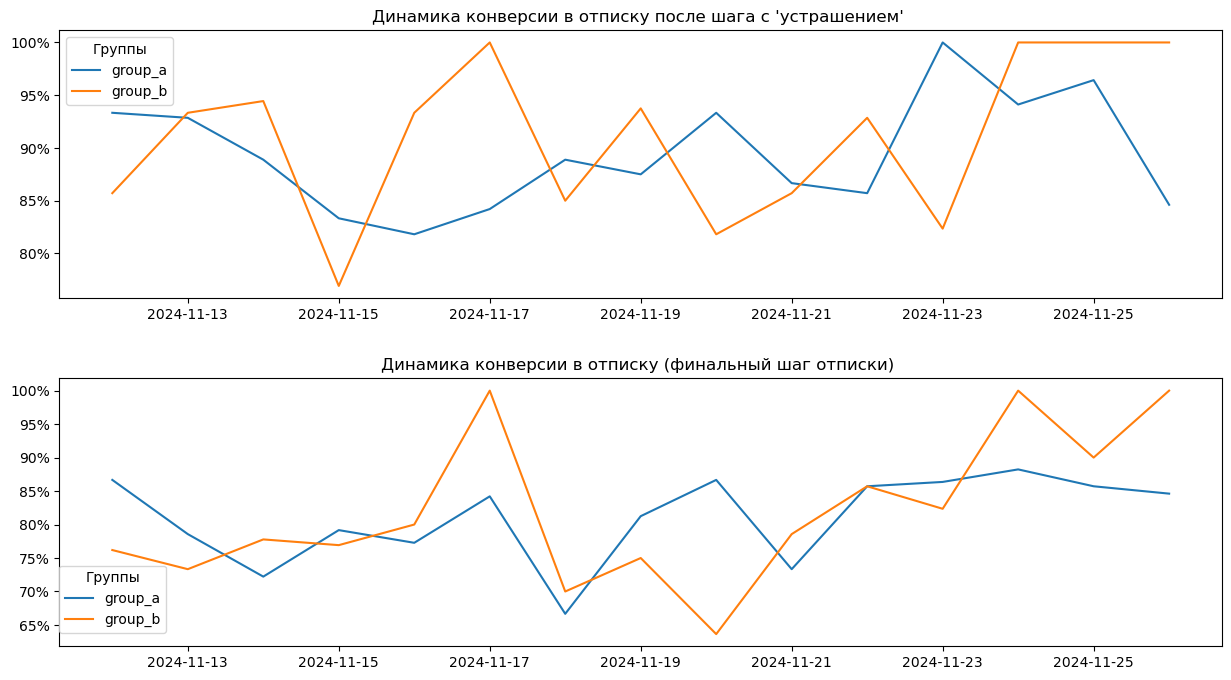

In [106]:
df_agg = df_experiment[df_experiment['client_type']=='web_desktop'].groupby(['date','flags'],as_index=False)[['click_subscribe_manage_cancel','click_subscribe_manage_popup','click_subscribe_cancel_last_chance']].sum()

df_agg['next_step_after_scare'] = df_agg['click_subscribe_manage_popup'] / df_agg['click_subscribe_manage_cancel']
df_agg['final_step'] = df_agg['click_subscribe_cancel_last_chance'] / df_agg['click_subscribe_manage_cancel']


fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(15,8))
sns.lineplot(data=df_agg,x='date',y='next_step_after_scare',hue='flags', ax=ax[0])
ax[0].set_title("Динамика конверсии в отписку после шага с 'устрашением' ")
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].legend(title='Группы')
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))


sns.lineplot(data=df_agg,x='date',y='final_step',hue='flags',ax=ax[1])
ax[1].set_title("Динамика конверсии в отписку (финальный шаг отписки) ")
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].legend(title='Группы',loc=(0,0.05))
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))

plt.subplots_adjust(hspace=0.3)
plt.show()  

### WEB mobile

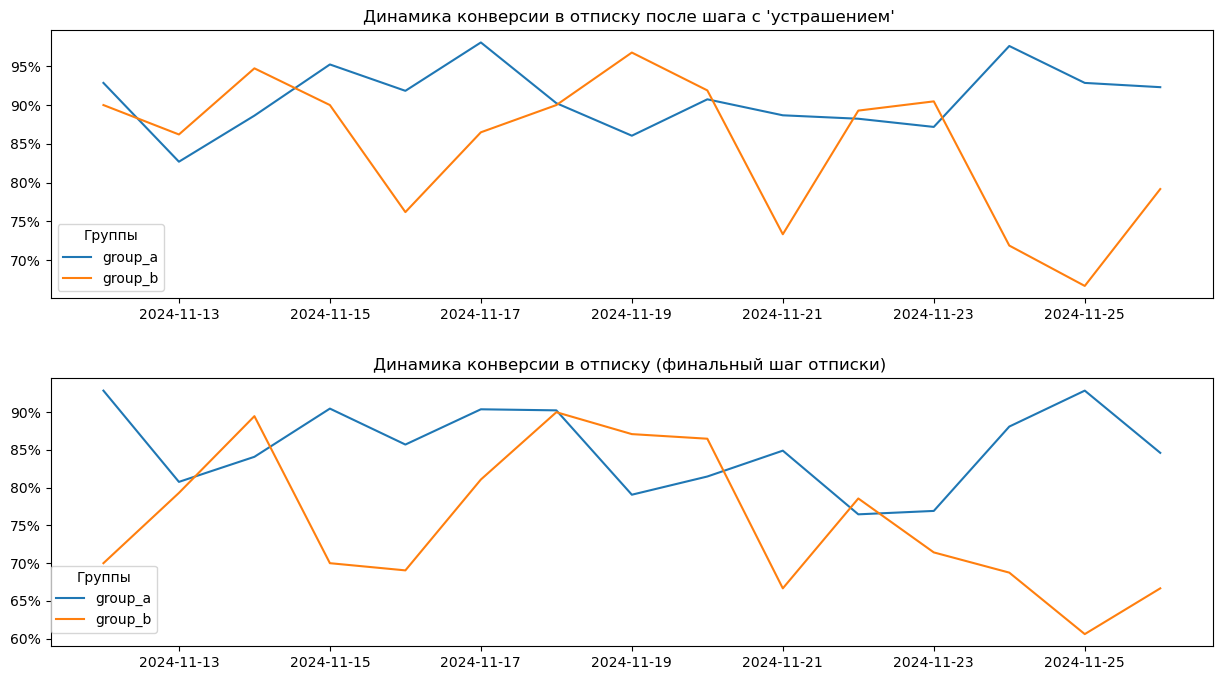

In [109]:
df_agg = df_experiment[df_experiment['client_type']=='web_mobile'].groupby(['date','flags'],as_index=False)[['click_subscribe_manage_cancel','click_subscribe_manage_popup','click_subscribe_cancel_last_chance']].sum()

df_agg['next_step_after_scare'] = df_agg['click_subscribe_manage_popup'] / df_agg['click_subscribe_manage_cancel']
df_agg['final_step'] = df_agg['click_subscribe_cancel_last_chance'] / df_agg['click_subscribe_manage_cancel']


fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(15,8))
sns.lineplot(data=df_agg,x='date',y='next_step_after_scare',hue='flags', ax=ax[0])
ax[0].set_title("Динамика конверсии в отписку после шага с 'устрашением' ")
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].legend(title='Группы')
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))


sns.lineplot(data=df_agg,x='date',y='final_step',hue='flags',ax=ax[1])
ax[1].set_title("Динамика конверсии в отписку (финальный шаг отписки) ")
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].legend(title='Группы',loc=(0,0.05))
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y * 100)}%'))

plt.subplots_adjust(hspace=0.3)
plt.show()  

## Группы эксперимента

In [112]:
control_group = 'group_a'
test_group_1 = 'group_b'

control = df_experiment[df_experiment['flags']==control_group]
test_1 = df_experiment[df_experiment['flags']==test_group_1]

num_of_bucket = 2

BOLD = "\033[1m"  
END = "\033[0m" 

## Тест на независимость 

In [115]:
# Функция для хи-квадра по определению независимости между выборками
def chi_independence(df, control, test_1, segment_name, part=None):
        '''H0: distributions are independent, H1: distributions are dependent '''
        for segment in segment_name:
                control1 = df[df['flags'] == control][segment].value_counts()
                test1 = df[df['flags'] == test_1][segment].value_counts()
                # test2 = df[df['experiment_group'] == test_2][segment].value_counts()
                # test3 = df[df['experiment_group'] == test_3][segment].value_counts()
                
                #concat = pd.concat([control1,test1,test2,test3], axis=1)
                #concat.columns = ['control_1','test_1','test_2','test_3']
                concat = pd.concat([control1,test1], axis=1)
                concat.columns = ['control','test_1']
                if part:
                    print(concat.iloc[:part])
                    stat, p_value, dof, expected = stats.chi2_contingency(concat.iloc[:part])
                else:
                    stat, p_value, dof, expected = stats.chi2_contingency(concat)

                if p_value <= 0.01:
                        print (f" {segment}- p-value: {p_value:.4f}, statistic: {stat:.4f}, dof: {dof}, dependent (reject H0)\n")
                else:
                        print (f" {segment} - p-value: {p_value:.4f}, statistic: {stat:.4f}, dof: {dof}, independent (fail to reject H0)\n")


In [117]:
chi_independence(df_experiment,
                  control_group,
                  test_group_1,
                 ['bonus_title_new','client_type','app_version'],
                 15
                )

                                        control  test_1
bonus_title_new                                        
Flocktory                                 526.0   377.0
                                          134.0    78.0
Яндекс Директ. 1 месяц за 1 рубль.        109.0    93.0
Get4Click                                  53.0    41.0
30 дней за 1 рубль. MediaNation            28.0    28.0
test                                       26.0    14.0
RIS                                        22.0    19.0
Perfluence                                 17.0    12.0
PROMO35                                    10.0     5.0
30 дней за 1 рубль. СРА-сетки. CityAds      3.0     4.0
PROMOKODUS                                  2.0     2.0
Sharry 3 мес 399 \ 45 дней                  2.0     2.0
VIJU29                                      2.0     2.0
email                                       1.0     1.0
Ставропольцев                               1.0     NaN
 bonus_title_new - p-value: nan, statistic: nan,

## Тест на SRM (тест на однородность)

In [120]:
def chi_homogeneity(df, control, test_1, segment_name,number_of_groups, part=None):
    '''H0: distributions are homogeneous, H1: distributions are not homogeneous '''
    for segment in segment_name:
            control1 = df[df['flags'] == control][segment].value_counts()
            test1 = df[df['flags'] == test_1][segment].value_counts()
            # test2 = df[df['experiment_group'] == test_2][segment].value_counts()
            # test3 = df[df['experiment_group'] == test_3][segment].value_counts()
            concat = pd.concat([control1,test1], axis=1)
            concat.columns = ['control_1','test_1']
            concat['expected']=concat.sum(axis=1).apply(lambda x: math.ceil(x / number_of_groups))
            print(concat.iloc[:part])
            for i in concat.columns[:-1]:
                    # рассчитываем статистику
                    k = len(concat[i].iloc[:part])                                                                                             # число степеней свободы 
                    statistic = (((concat[i].iloc[:part] - concat['expected'].iloc[:part])**2)/concat['expected'].iloc[:part]).sum()           # КСП
                    # рассчитываем p-value 
                    p_value = 1 - stats.chi2.cdf(statistic, k - 1)                                                                             # вероятность получить значение выше или равное статистике
                    if p_value <= 0.01:
                            print (f" {segment}- p-value: {p_value:.4f}, statistic: {statistic:.4f}, dof: {k-1}, homogenes (reject H0)\n")
                    else:
                            print (f" {segment} - p-value: {p_value:.4f}, statistic: {statistic:.4f}, dof: {k-1}, not homogenes (fail to reject H0)\n")


In [122]:
chi_homogeneity(df_experiment,
                  control_group,
                  test_group_1,
                 segment_name = ['bonus_title_new','client_type','app_version'],
                 number_of_groups = 2,
                 part = 10
                )

                                        control_1  test_1  expected
bonus_title_new                                                    
Flocktory                                   526.0   377.0       452
                                            134.0    78.0       106
Яндекс Директ. 1 месяц за 1 рубль.          109.0    93.0       101
Get4Click                                    53.0    41.0        47
30 дней за 1 рубль. MediaNation              28.0    28.0        28
test                                         26.0    14.0        20
RIS                                          22.0    19.0        21
Perfluence                                   17.0    12.0        15
PROMO35                                      10.0     5.0         8
30 дней за 1 рубль. СРА-сетки. CityAds        3.0     4.0         4
 bonus_title_new- p-value: 0.0047, statistic: 23.7752, dof: 9, homogenes (reject H0)

 bonus_title_new- p-value: 0.0030, statistic: 24.9560, dof: 9, homogenes (reject H0)

            

## Распределение

In [125]:
def plot_segments_distribution(df, segment_columns, test_factor):
    for i in segment_columns:
        aggregated_data = df.groupby(by = [test_factor,i])['user_id'].count().reset_index()
        sns.catplot(x = i, 
                    y = 'user_id', 
                    hue = test_factor, # сообщаем, что хотим, чтобы разные группы имели разный цвет
                    data = aggregated_data.sort_values(by='user_id', ascending=False).iloc[:40], 
                    kind = "bar", 
                    height = 4, # задаем размер графика 
                    aspect = 1.5) # задаем ширину столбца
        plt.xticks(rotation=100)

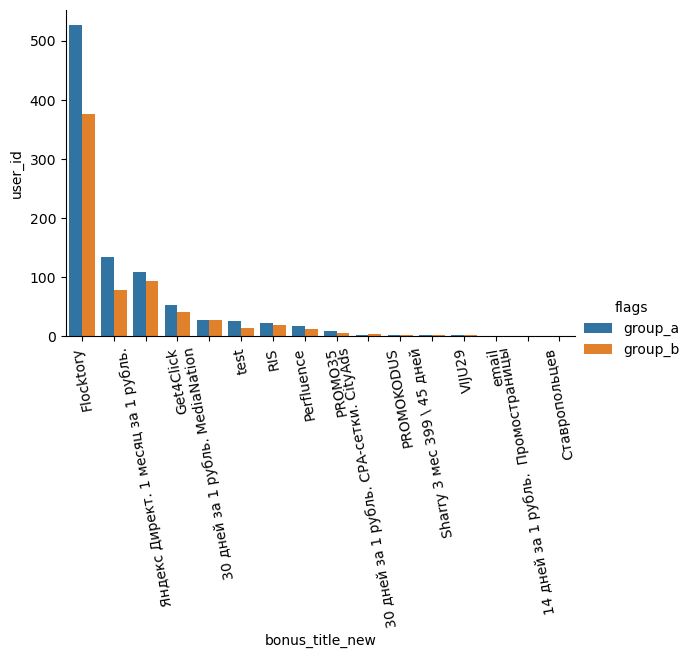

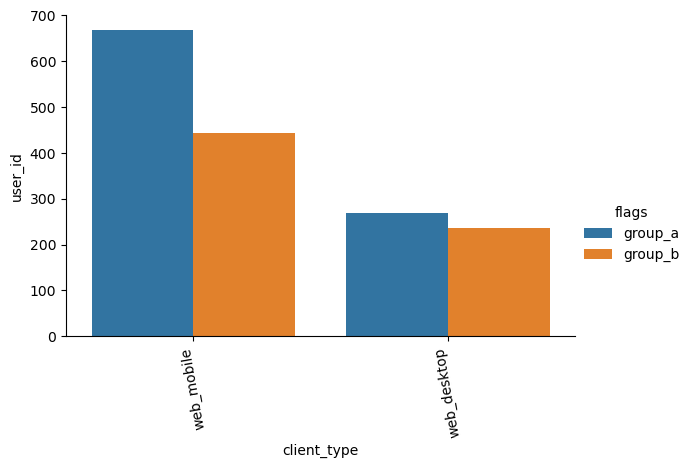

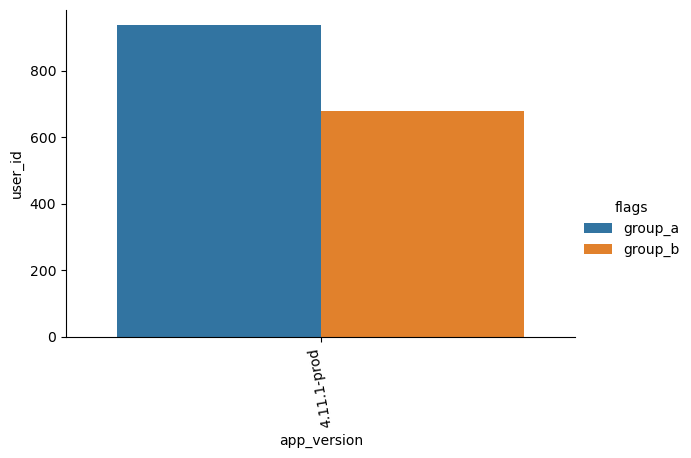

In [127]:
plot_segments_distribution(df_experiment, #датафрейм
                          ['bonus_title_new','client_type','app_version'],
                           "flags",) #тест-фактор

## Квантильный анализ

## Постстратификация

In [131]:
def calculate_stratified_mean(df, weights,parameter):
    strat_mean = df.groupby('bonus_title_new')[parameter].mean()
    df_means_weights = pd.merge(
        strat_mean,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_means_weights['weight'] = df_means_weights['weight'] / df_means_weights['weight'].sum()
    mean_strat = (df_means_weights['weight'] * df_means_weights[parameter]).sum()
    return mean_strat

In [133]:
def calculate_strat_var(df, weights, parameter):
    """Вычисляет стратифицированную дисперсию."""
    """ Parametr - поле конверсии """
    strat_vars = df.groupby('bonus_title_new')[parameter].var()
    df_vars_weights = pd.merge(
        strat_vars,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_vars_weights['weight'] = df_vars_weights['weight'] / df_vars_weights['weight'].sum()
    var_strat = (df_vars_weights['weight'] * df_vars_weights[parameter]).sum()
    return var_strat

In [135]:
def check_stratified_test(df_control, df_pilot, weights, parameter):
    """Проверяет гипотезу о равенстве средних для стратифицированного среднего."""
    mean_strat_control = calculate_stratified_mean(df_control, weights, parameter)
    mean_strat_pilot = calculate_stratified_mean(df_pilot, weights, parameter)
    var_strat_control = calculate_strat_var(df_control, weights, parameter)
    var_strat_pilot = calculate_strat_var(df_pilot, weights, parameter)
    delta_mean_strat = mean_strat_pilot - mean_strat_control
    std_mean_strat = (var_strat_pilot / len(df_pilot) + var_strat_control / len(df_control)) ** 0.5
    t = delta_mean_strat / std_mean_strat
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue

In [137]:
weights = df_experiment['bonus_title_new'].value_counts(normalize=True).to_dict()

print(calculate_strat_var(df_experiment,weights,'click_subscribe_cancel_last_chance'))
print(df_experiment['click_subscribe_cancel_last_chance'].var())

0.14778314248116745
0.15173501214220364


## Симмуляция Монте-Карло для контроля ошибок I и II рода

In [140]:
def mde_estimated_absolute (ttl_users,var,alpha,beta):
    """ Учитываем поправку на множественное тестирование и снижаем альфу по методу Бонферрони """
    t_alpha = stats.norm.ppf(1 - alpha /(num_of_bucket - 1) / 2, loc=0, scale=1)
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    var = var * 2
    MDE=(t_alpha+t_beta) * np.sqrt(var / ttl_users)
    return MDE

In [142]:
ttl_users = math.ceil(df_experiment['user_id'].count() / num_of_bucket)
var = df_experiment['click_subscribe_cancel_last_chance'].var()
mean = df_experiment['click_subscribe_cancel_last_chance'].mean()

mde_absolute = mde_estimated_absolute(ttl_users,var,0.05,0.2)
MDE = mde_absolute / mean
print(f"{BOLD}Период(дни) - 7 {END}") 
print('MDE абсолютный:',round(mde_absolute,4))
print('MDE относительный:',round(MDE,4))
print('Среднияя конверсия в отписку:',round(mean,4))
print('Дисперсия:',round(var,4))
print('Число пользователей в группе:',math.ceil(ttl_users))

Период(дни) - 7 
MDE абсолютный: 0.0543
MDE относительный: 0.0667
Среднияя конверсия в отписку: 0.8136
Дисперсия: 0.1517
Число пользователей в группе: 808


100%|██████████| 1000/1000 [00:00<00:00, 1843.47it/s]



Эффект = 0
Период (дни) - 7 дней
Итераций с p_value < 0.05: 61
Число пользователей всего: 1574

Эффект = 0.0667
Период (дни) - 7 дней
Итераций с p_value < 0.05: 745
Число пользователей всего: 1574


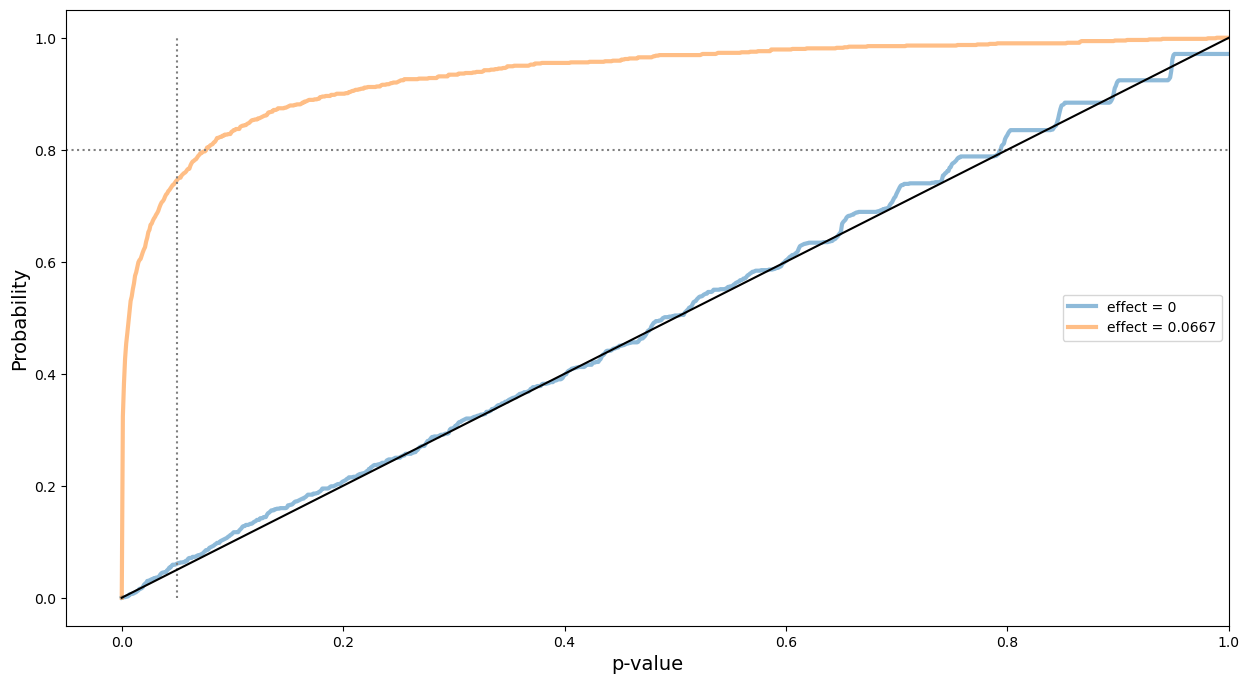

In [144]:
effects = [0,0.0667]

# Хранение p-values для каждого значения эффекта
pvalues_dict = {}


for effect in effects:
    ttl_users = math.ceil(df_experiment['user_id'].nunique() / num_of_bucket)
    pvalues_ttest = []
    for i in tqdm(range(1000)):
    
        df_control = df_experiment.sample(n=ttl_users, replace=True)
        df_pilot = df_experiment.sample(n=ttl_users, replace=True)
        df_pilot = df_pilot['click_subscribe_cancel_last_chance'] * (1 + effect)

        # Проведение t-теста
        _,p_value = ttest_ind(df_control['click_subscribe_cancel_last_chance'], df_pilot)
        pvalues_ttest.append(p_value)
        
    pvalues_dict[effect] = pvalues_ttest  # Сохраняем p-values для текущего эффекта
        

# Визуализация результатов
plt.figure(figsize=(15, 8))
X = np.linspace(0, 1, 1000)

for effect, pvalues in pvalues_dict.items():
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=f'effect = {effect}')
    print()
    print(f"Эффект = {effect}")
    print(f"Период (дни) - 7 дней")
    print(f'Итераций с p_value < 0.05:', len([p for p in pvalues if p < 0.05]))
    print(f'Число пользователей всего:', ttl_users * 2)

plt.xlabel('p-value', size=14)
x_values = [0.05]
plt.vlines(x_values, ymin=0, ymax=1, linestyles='dotted', colors='gray')
plt.axhline(y=0.8, color='gray', linestyle='dotted')
plt.xlim([-0.05, 1])
plt.ylabel('Probability', size=14)
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()

## Подсчет среднего и критериев

In [147]:
weights = df_experiment['bonus_title_new'].value_counts(normalize=True).to_dict()

unsubscribe_cr_control = calculate_stratified_mean(control, weights, 'click_subscribe_cancel_last_chance')
unsubscribe_cr_test = calculate_stratified_mean(test_1, weights, 'click_subscribe_cancel_last_chance')
unsubscribe_test_to_control = check_stratified_test(control, test_1, weights, 'click_subscribe_cancel_last_chance')



next_step_after_scare_cr_control = control['click_subscribe_manage_popup'].mean()
next_step_after_scare_cr_test = test_1['click_subscribe_manage_popup'].mean()
next_step_after_scare_test_to_control = ttest_ind(control['click_subscribe_manage_popup'],test_1['click_subscribe_manage_popup'],equal_var=False)[1]

In [153]:
final_table_register = []

row1 = [unsubscribe_cr_control, unsubscribe_cr_test, unsubscribe_test_to_control]
row2 = [next_step_after_scare_cr_control, next_step_after_scare_cr_test, next_step_after_scare_test_to_control]

final_table_register.append(row1)
final_table_register.append(row2)



final_table_register = pd.DataFrame(final_table_register, index=['Конверсия в отписку','Конверсия в следующий шаг после "устрашения"'], columns=['Контроль', 'Тест', 'p_value'])
final_table_register['Тест к контролю (%)'] = np.where(final_table_register['p_value'].isna(), 0, np.where(final_table_register['p_value']<0.05/num_of_bucket, round((final_table_register['Тест'] / final_table_register['Контроль'] - 1) * 100,3), 'Нет различия'))
final_table_register['Тест к контролю (п.п.)'] = np.where(final_table_register['p_value'].isna(), 0, np.where(final_table_register['p_value']<0.05/num_of_bucket, round((final_table_register['Тест'] - final_table_register['Контроль']),3), 'Нет различия'))
final_table_register[['Контроль','Тест']] = final_table_register[['Контроль','Тест']].round(3).astype('str')

final_table_register

,Контроль,Тест,p_value,Тест к контролю (%),Тест к контролю (п.п.)
Конверсия в отписку,0.842,0.771,0.000292,-8.531,-0.072
"Конверсия в следующий шаг после ""устрашения""",0.905,0.863,0.010395,-4.628,-0.042


### Функция закраски

In [156]:
def color_cell(val):
    if val == 'Нет различия':
        return ''
    elif '+' in val:
        return 'background-color: lightgreen'
    else:
        return 'background-color:  #FFCCCB'

In [158]:
final_table_register[['Контроль', 'Тест','Тест к контролю (%)', 'Тест к контролю (п.п.)']].style.applymap(color_cell, subset=['Тест к контролю (%)','Тест к контролю (п.п.)'])

,Контроль,Тест,Тест к контролю (%),Тест к контролю (п.п.)
Конверсия в отписку,0.842,0.771,-8.531,-0.072
"Конверсия в следующий шаг после ""устрашения""",0.905,0.863,-4.628,-0.042


## Доп исследование по метрике конверсия в платящего и количество денег

In [166]:
query = f''' SELECT user_id,min(paid_date) as min_paid_date,payment
             FROM datamarts.finance  
             WHERE paid_date>='2024-11-01' 
             GROUP BY 1,3
'''

df_paid = execute(query,user='kmekhtiev')
df_paid['min_paid_date'] = df_paid['min_paid_date'].astype('datetime64[ns]')

Время выполнения функции: 0.8 секунд



In [168]:
df_paid

,user_id,min_paid_date,payment
0,edc48173-905f-494f-ac30-a7df07bbd393,2024-11-16,399
1,e8c10d78-da89-40ad-b655-437638748f1d,2024-11-30,299
2,ec4f9a38-01c4-49e6-87dd-0e2100dc2da8,2024-11-19,399
3,532797bf-541f-40be-b29f-8623df953afd,2024-12-04,399
4,21987df2-a8aa-4772-80b3-6fc2aead8a25,2024-11-07,199
...,...,...,...
5853,bcfe43f1-69fb-4405-a445-cf84102659e3,2024-11-19,399
5854,01ce2d28-234d-433f-aade-5e3385618285,2024-11-26,399
5855,b55dc776-4a3d-469d-a0af-8d39b5d60688,2024-11-23,399
5856,7d45e94f-be68-4419-ac89-2e077f648008,2024-12-10,499


In [234]:
df_merge = pd.merge(df_experiment,df_paid,on='user_id',how='left')
df_merge[df_merge['min_paid_date'].notna()]
df_merge['subs'] = df_merge['payment'].apply(lambda x: 0 if pd.isna(x) else 1)

In [240]:
p = df_merge.groupby('flags')[['click_subscribe_manage_cancel','subs','payment']].sum().reset_index()
p['conv'] = p['subs'] / p['click_subscribe_manage_cancel']
p['ARPPU'] = p['payment'] / p['subs']
p

,flags,click_subscribe_manage_cancel,subs,payment,conv,ARPPU
0,group_a,936,53,19447.0,0.056624,366.924528
1,group_b,679,61,22835.0,0.089838,374.344262


In [214]:
control = df_merge[df_merge['flags']==control_group]
test_1 = df_merge[df_merge['flags']==test_group_1]

# Проверим конверсию в подписку
_,p_value = ttest_ind(control['conv_subs'], test_1['conv_subs'])
print(p_value)

0.01008077256619891


In [220]:
# Проверим arpu
_,p_value = ttest_ind(control[control['conv_subs']==1]['payment'], test_1[test_1['conv_subs']==1]['payment'])
print(p_value)

0.5351294067644818


<Axes: xlabel='payment', ylabel='Count'>

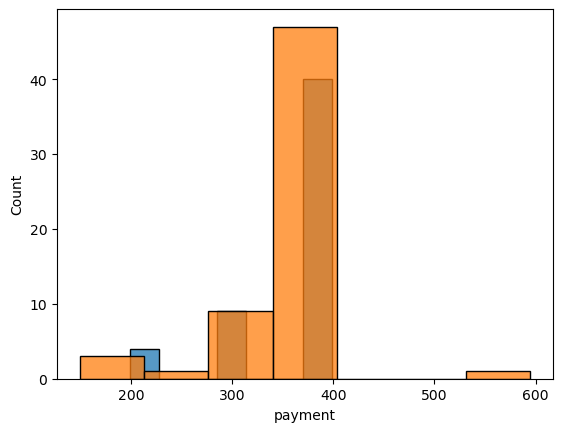

In [226]:
sns.histplot(control,x='payment')
sns.histplot(test_1,x='payment')

In [230]:
control['payment'].unique()
test_1['payment'].unique()

array([ nan, 399., 299., 249., 149., 199., 595.])